In [1]:
#%tensorflow_version 1.x 
#!pip install tensorflow-hub

In [36]:
#import tensorflow_hub as hub
import tensorflow as tf
from keras import backend as K

import pandas as pd
import numpy as np

import os

import re

%matplotlib inline
import matplotlib.pyplot as plt

import emoji

import urllib.request


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import WordPunctTokenizer  
from tensorflow.keras.preprocessing.text import text_to_word_sequence

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
#https://www.kaggle.com/uciml/sms-spam-collection-dataset

In [4]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/reejungkim/Natural-Language-Processing/master/spam.csv", filename="spam.csv")
data = pd.read_csv('spam.csv',encoding='latin1')
data[:5]

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
del data['Unnamed: 2']
del data['Unnamed: 3']
del data['Unnamed: 4']
data['v1'] = data['v1'].replace(['ham','spam'],[0,1])
data[:5]

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
data.drop_duplicates(subset=['v2'], inplace=True)

# EDA

In [7]:
data.v1.isnull().sum()

0

In [8]:
data.shape

(5169, 2)

#### example of spam texts

In [9]:
spam = data[data.v1==1]
spam.reset_index(drop=True, inplace=True)

In [10]:
for i in range(0, 10):
    print(i ,". ", spam.v2[i] ) 

0 .  Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
1 .  FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv
2 .  WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
3 .  Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030
4 .  SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info
5 .  URGENT! You have won a 1 week FREE membership in our å£100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18
6 .  XXXMobileMovieClub: To use your credit, click the WA

#### example of non-spam texts

In [11]:
ham = data[data.v1==0]
ham.reset_index(drop=True, inplace=True)

In [12]:
for i in range(0, 10):
    print(i ,". ", ham.v2[i] ) 

0 .  Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
1 .  Ok lar... Joking wif u oni...
2 .  U dun say so early hor... U c already then say...
3 .  Nah I don't think he goes to usf, he lives around here though
4 .  Even my brother is not like to speak with me. They treat me like aids patent.
5 .  As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
6 .  I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.
7 .  I've been searching for the right words to thank you for this breather. I promise i wont take your help for granted and will fulfil my promise. You have been wonderful and a blessing at all times.
8 .  I HAVE A DATE ON SUNDAY WITH WILL!!
9 .  Oh k...i'm watching here:)


## URL extraction

In [13]:
def find_url(string): 
    text = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',string)
    if text!=[]:
        return "".join(text)
    return None

In [14]:
data.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [15]:
data['url']= data['v2'].apply(lambda x:find_url(x))
data.loc[pd.notnull(data.url)].head(5)

,v1,v2,url
15,1,"XXXMobileMovieClub: To use your credit, click ...",http://wap.
304,1,SMS. ac Blind Date 4U!: Rodds1 is 21/m from Ab...,http://img.
517,1,Your credits have been topped up for http://ww...,http://www.bubbletext.com
634,1,"Dear Voucher Holder, 2 claim this weeks offer,...",http://www.e-tlp.co.uk/expressoffer
832,1,"Dear Voucher Holder, To claim this weeks offer...",http://www.e-tlp.co.uk/expressoffer


## Emoji extraction

In [16]:
def extract_emojis(string):
    emoticon = "".join(c for c in string if c in emoji.UNICODE_EMOJI)
    if emoticon!="":
        return emoticon
    return None

extract_emojis("😘😳😍test")

'😘😳😍'

In [17]:
data['emoji']= data['v2'].apply(lambda x: extract_emojis(x))

In [18]:
data.emoji.nunique()

1

#### There's no emoji used in the data set text

## Clean data text

#### remove URLs from texts

In [32]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [33]:
data['v2']=data['v2'].apply(lambda x : remove_URL(x))

In [34]:
data.head()

,v1,v2,url,emoji
0,0,"Go until jurong point, crazy.. Available only ...",None,None
1,0,Ok lar... Joking wif u oni...,None,None
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,None,None
3,0,U dun say so early hor... U c already then say...,None,None
4,0,"Nah I don't think he goes to usf, he lives aro...",None,None


## Remove words that doesn't add much meanings
 stopwords: words which does not add much meaning to a sentence

In [52]:
stops = set(stopwords.words('english'))

## Lemmatizing texts

Lemmatization is the process of converting a word to its base form. The difference between stemming and lemmatization is, lemmatization considers the context and converts the word to its meaningful base form, whereas stemming just removes the last few characters, often leading to incorrect meanings and spelling errors.

In [67]:
from nltk.stem import PorterStemmer, LancasterStemmer, SnowballStemmer, WordNetLemmatizer

#types of stemmers
stemmerS = SnowballStemmer('english')  
stemmerP = PorterStemmer()
stemmerL = LancasterStemmer()
lm = WordNetLemmatizer()   #<-- recommended to be used

In [68]:
words =['fly', 'flies', 'flew', 'flown']

OutputSnowball=[stemmerS.stem(word) for word in words]
OutputPorter=[stemmerP.stem(word) for word in words]
OutputLancaster=[stemmerL.stem(word) for word in words]

print("using Snowball stemmer: ", OutputSnowball)
print("using Porter stemmer: ", OutputPorter)
print("using Lancaster stemmer: ", OutputLancaster)

using Snowball stemmer:  ['fli', 'fli', 'flew', 'flown']
using Porter stemmer:  ['fli', 'fli', 'flew', 'flown']
using Lancaster stemmer:  ['fly', 'fli', 'flew', 'flown']


In [71]:
print(lm.lemmatize("flying"))

flying


In [72]:
print(lm.lemmatize("flying", pos='v'))

fly


In [73]:
Output=[lm.lemmatize(word, pos="v") for word in words]
print("using Lemmatizer: " , Output)

using Lemmatizer:  ['fly', 'fly', 'fly', 'fly']


In [74]:
def language_preprocessor(string):
    text =  re.sub('[^a-zA-Z]', ' ', string) #replace non-english with blank
    text = text.lower().split() #decapitalize texts
    text = [word for word in text if not word in stops] #remove stopword
    text = [lm.lemmatize(word) for word in text]  #lemmatization of texts
    return text #' '.join(text)  #text
    

In [75]:
data['text processed'] = data['v2'].apply(lambda x: language_preprocessor(x)) 

In [76]:
data.head()

,v1,v2,url,emoji,text processed
0,0,"Go until jurong point, crazy.. Available only ...",None,None,"[go, jurong, point, crazy, available, bugis, n..."
1,0,Ok lar... Joking wif u oni...,None,None,"[ok, lar, joking, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,None,None,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,0,U dun say so early hor... U c already then say...,None,None,"[u, dun, say, early, hor, u, c, already, say]"
4,0,"Nah I don't think he goes to usf, he lives aro...",None,None,"[nah, think, go, usf, life, around, though]"


# tokenization

In [19]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.v2)
sequences = tokenizer.texts_to_sequences(data.v2) 

In [20]:
X_data = sequences

In [21]:
word_to_index = tokenizer.word_index

word_to_index

# padding

In [22]:
vocab_size = len(word_to_index) + 1
print('number of vocabs in the dict: {}'.format((vocab_size)))

number of vocabs in the dict: 8921


In [23]:
max(len(item) for item in X_data)

189

In [24]:
max_len = max(len(item) for item in X_data)

X_data = pad_sequences(X_data, maxlen = max_len)
print("data(shape): ", X_data.shape)

data(shape):  (5169, 189)


# model 

In [25]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X_data, 
                                                    data.v1,
                                                    test_size=0.2, 
                                                    random_state=0)

In [26]:
np.array(X_train).shape, np.array(y_train).shape

((4135, 189), (4135,))

In [27]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential

In [28]:
model = Sequential()
model.add(Embedding(vocab_size, 32)) 
model.add(SimpleRNN(32)) 
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, np.array(y_train), epochs=4, batch_size=64, validation_split=0.2)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 3308 samples, validate on 827 samples
Epoch 1/4
3308/3308 [==============================] - 2s 529us/sample - loss: 0.3803 - acc: 0.8727 - val_loss: 0.2365 - val_acc: 0.9395
Epoch 2/4
3308/3308 [==============================] - 1s 445us/sample - loss: 0.1238 - acc: 0.9707 - val_loss: 0.1023 - val_acc: 0.9637
Epoch 3/4
3308/3308 [==============================] - 1s 444us/sample - loss: 0.0623 - acc: 0.9849 - val_loss: 0.0714 - val_acc: 0.9782
Epoch 4/4
3308/3308 [==============================] - 1s 443us/sample - loss: 0.0420 - acc: 0.9867 - val_loss: 0.0565 - val_acc: 0.9843


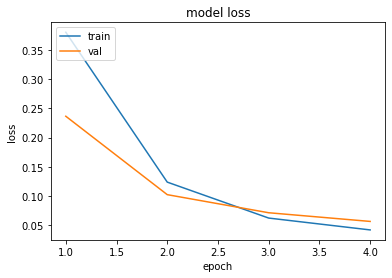

In [29]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

print("\n model accuracy: %.4f" % (model.evaluate(X_test, np.array(y_test)))[1])

In [30]:
X_test.shape, np.array(y_test).shape

((1034, 189), (1034,))

In [31]:
model.evaluate(X_test, np.array(y_test))

1034/1034 [==============================] - 0s 165us/sample - loss: 0.0622 - acc: 0.9807


[0.06224351602910912, 0.98065764]